In [1]:
import pymongo
import pandas as pd
from datetime import datetime, timedelta
import time
from pymongo import MongoClient
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import folium

host_ip = "192.168.68.124" #jx

In [4]:
client = MongoClient('192.168.68.124', 27017)
# Test connection
try:
    client.server_info()
    print("MongoDB connection successful!")
except Exception as e:
    print("MongoDB connection failed:", e)

db = client["traffic_monitoring"]
violation_collection = db["violation"]
camera_collection = db["camera"]

MongoDB connection successful!


In [5]:
print("Total documents:", db.violation.count_documents({}))

Total documents: 50000


In [6]:
# 1. Get latest violation timestamp (already done in your code)
latest_time = violation_collection.aggregate([
    {"$unwind": "$violation_records"},
    {"$sort": {"violation_records.timestamp_end": -1}},
    {"$limit": 1}
])
latest_time = next(latest_time, {}).get("violation_records", {}).get("timestamp_end", datetime.utcnow())

# 2. Define 60-minute time window
window_start = latest_time - timedelta(minutes=60)

# 3. Query violation events in the last 60 minutes
events = violation_collection.aggregate([
    {"$unwind": "$violation_records"},
    {"$match": {
        "violation_records.timestamp_end": {"$gte": window_start, "$lte": latest_time}
    }}
])

# 4. Group data by 10-minute time buckets
violation_counts = defaultdict(int)
speeds = defaultdict(list)

for doc in events:
    record = doc["violation_records"]
    ts = record["timestamp_end"]
    ts_bucket = ts.replace(minute=(ts.minute // 10) * 10, second=0, microsecond=0)  # bin into 10-minute intervals

    violation_counts[ts_bucket] += 1
    speeds[ts_bucket].append(record["speed_reading"])

# 5. Sort and extract lists
x_timestamps = sorted(violation_counts.keys())  # x-axis time values

y_violation = [violation_counts[ts] for ts in x_timestamps]  # y-axis: number of violations
y_speed = [round(sum(speeds[ts])/len(speeds[ts]), 2) for ts in x_timestamps]  # y-axis: avg speed per bin


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


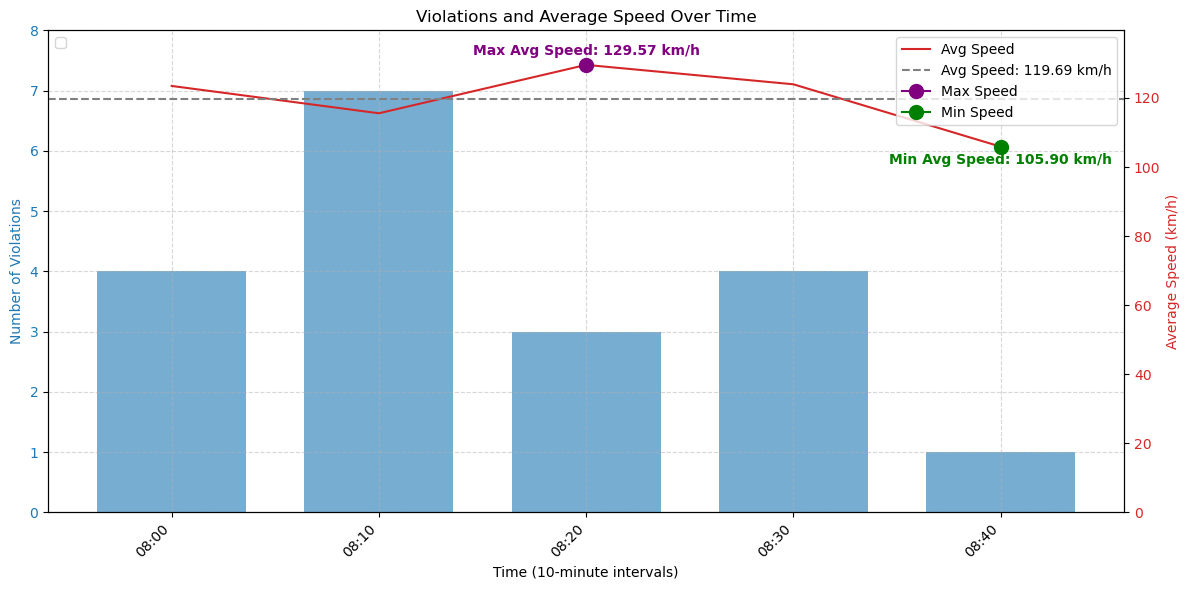

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Bar plot (violations)
ax1.bar(x_timestamps, y_violation, color='tab:blue', alpha=0.6, width=0.005)
ax1.set_ylabel("Number of Violations", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(y_violation) + 1)

# Line plot (average speed)
ax2.plot(x_timestamps, y_speed, color='tab:red', label='Avg Speed')
avg_speed = round(sum(y_speed) / len(y_speed), 2)
ax2.axhline(avg_speed, linestyle='--', color='gray', label=f"Avg Speed: {avg_speed} km/h")
ax2.set_ylabel("Average Speed (km/h)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(y_speed) + 10)

# --- Highlight Max Point on Avg Speed Line ---
max_speed = max(y_speed)
max_index = y_speed.index(max_speed)
max_time = x_timestamps[max_index]

# Purple circular marker
ax2.plot(max_time, max_speed, marker='o', color='purple', markersize=10, label='Max Speed')

# Label above the marker
ax2.text(
    max_time,
    max_speed + 3,
    f'Max Avg Speed: {max_speed:.2f} km/h',
    color='purple',
    fontsize=10,
    ha='center',
    fontweight='bold'
)

# --- Highlight Min Point on Avg Speed Line ---
valid_speeds = [(i, val) for i, val in enumerate(y_speed) if val > 0]
min_index, min_speed = min(valid_speeds, key=lambda t: t[1])
min_time = x_timestamps[min_index]

# Green circular marker
ax2.plot(min_time, min_speed, marker='o', color='green', markersize=10, label='Min Speed')

# Label below the marker
ax2.text(
    min_time,
    min_speed - 5,  # adjust if needed
    f'Min Avg Speed: {min_speed:.2f} km/h',
    color='green',
    fontsize=10,
    ha='center',
    fontweight='bold'
)

# Format x-axis
ax1.set_xticks(x_timestamps[::max(len(x_timestamps)//10, 1)])
ax1.set_xticklabels([ts.strftime('%H:%M') for ts in x_timestamps], rotation=45, ha='right')

ax1.set_xlabel("Time (10-minute intervals)")
ax1.set_title("Violations and Average Speed Over Time")
ax1.grid(True, linestyle='--', alpha=0.5)

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [8]:
!pip install folium

In [9]:
df_camera = pd.read_csv("data/camera.csv")
center_lat = df_camera['latitude'].mean()
center_lon = df_camera['longitude'].mean()
fomap = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# Step 2: Add camera markers
for _, row in df_camera.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Camera {int(row['camera_id'])}<br>Speed Limit: {row['speed_limit']} km/h",
        icon=folium.Icon(color='blue', icon='camera', prefix='fa')
    ).add_to(fomap)
    
# Step 3: Aggregate violation counts between camera pairs from MongoDB
pipeline = [
    {"$unwind": "$violation_records"},
    {"$group": {
        "_id": {
            "start": "$violation_records.camera_id_start",
            "end": "$violation_records.camera_id_end"
        },
        "count": {"$sum": 1}
    }}
]

violation_links = list(violation_collection.aggregate(pipeline))

# Step 4: Add lines between checkpoints
for v in violation_links:
    start_id = v['_id']['start']
    end_id = v['_id']['end']
    count = v['count']

    # Lookup coordinates dynamically
    start_row = df_camera[df_camera['camera_id'] == start_id]
    end_row = df_camera[df_camera['camera_id'] == end_id]

    if not start_row.empty and not end_row.empty:
        start_coords = [start_row.iloc[0]['latitude'], start_row.iloc[0]['longitude']]
        end_coords = [end_row.iloc[0]['latitude'], end_row.iloc[0]['longitude']]
        
        folium.PolyLine(
            locations=[start_coords, end_coords],
            color='red' if count > 10000 else 'orange',
            weight=4,
            tooltip=f"{count} violations" # hover over to see
        ).add_to(fomap)

        
        
        
# Step 1: Define threshold and time window
threshold = 1000
target_date = datetime(2018, 1, 1)  
next_day = datetime(2019, 1, 1)

# Step 2: Aggregate total violations per camera_id_start for a specific day
hotspot_pipeline = [
    {"$unwind": "$violation_records"},
    {"$match": {
        "violation_records.timestamp_start": {
            "$gte": target_date,
            "$lt": next_day
        }
    }},
    {"$group": {
        "_id": "$violation_records.camera_id_start",
        "count": {"$sum": 1}
    }},
    {"$match": {"count": {"$gt": threshold}}}
]

hotspots = list(violation_collection.aggregate(hotspot_pipeline))

# Step 3: Highlight hotspot cameras
for h in hotspots:
    cam_id = h['_id']
    count = h['count']
    
    cam_row = df_camera[df_camera['camera_id'] == cam_id]
    if not cam_row.empty:
        coords = [cam_row.iloc[0]['latitude'], cam_row.iloc[0]['longitude']]
        folium.CircleMarker(
            location=coords,
            radius=10,
            color='red',
            fill=True,
            fill_color='red',
            popup=f"HOTSPOT!\nCamera {cam_id}\n{count} violations on {target_date.date()}",
            tooltip="🚨 Hotspot"
        ).add_to(fomap)        

fomap



In [10]:
print("HOTSPOTS FOUND:", len(hotspots))
for h in hotspots:
    print(f"Camera {h['_id']} = {h['count']} violations")


HOTSPOTS FOUND: 2
Camera 1 = 5731 violations
Camera 2 = 2633 violations


In [11]:
# building violation counts between camera pairs
for link in violation_links[:5]:
    print(link)

{'_id': {'start': 2, 'end': 3}, 'count': 16062}
{'_id': {'start': 1, 'end': 2}, 'count': 33938}


In [12]:
#Between Camera 1 and Camera 2, there were 33,938 recorded violations
#Between Camera 2 and Camera 3, there were 16,062 recorded violations